# Actor Critic Policy Optimization with PyTorch

In this notebook, we will look at policy optimization using PyTorch. Let us quickly go through the derivation of what is policy Optimization and then we will apply this to CartPole environment. 


### Derivation of Policy Gradient
In Policy Optimization, we will have a neural network which takes in state `s` as input and produces the `logits` for action probabilities. 

The policy is parameterized by $\theta$
$$\pi_\theta(a|s)$$

The agent follows the policy and generates the trajectory $\large \tau$ 

$$ s_1 \rightarrow a_1 \rightarrow s_2 \rightarrow a_2 \rightarrow .... \rightarrow s_{T-1} \rightarrow a_{T-1} \rightarrow s_T \rightarrow a_T$$ 

here $s_T$ is not necessarily the terminal state but some time horizon T upto which we are looking at the trajectory. 

The probability of trajectory $\large \tau$ depends on the transition probabilities $p(s_t+1 | s_t, a_t)$ and the policy $\pi_\theta(a_t|s_t)$. It is given by the expression:

$$p_\theta(\tau) = p_\theta(s_1, a_1, s_2, a_2, ..., s_T, a_T) = p(s_1)\prod_{t=1}^{T}\pi_\theta(a_t|s_t)p(s_{t+1}|s_t,a_t)$$

The expected return from following the policy $\pi$ is given by:

$$J(\theta) = {\large E}_{\tau \sim p_\theta(\tau)} \left[ \sum_{t} \gamma^t r(s_t, a_t) \right]$$

We want to find the $\theta$ which maximizes the expected reward/return $J(\theta)$. In other words, the optimal $\theta=\theta^*$ is given by expression

$$\theta^* = arg \underset{\theta}{max}{\large E}_{\tau \sim p_\theta(\tau)} \left[ \sum_{t} \gamma^t r(s_t, a_t) \right] $$

Moving on, let us try to find the optimal $\theta$. To keep the notations easier to understand, we will replace $\sum_{t} \gamma^t r(s_t, a_t)$ as $r(\tau)$:

$$J(\theta) = {\large E}_{\tau \sim p_\theta(\tau)} \left[ r(\tau) \right] = \int p_\theta(\tau)r(\tau) d\tau$$

We take the gradient/derivative of above expression with respect to $\theta$:

$$\nabla_{\theta} J(\theta) =  \nabla_{\theta} \int p_\theta(\tau)r(\tau) d\tau $$

By linearity we can move the gradient inside the integral:

$$\nabla_{\theta} J(\theta) =  \int \nabla_{\theta} p_\theta(\tau)r(\tau) d\tau $$

Using log derivative trick, we know that $\nabla_x f(x) = f(x) \nabla_x \log{f(x)}$. Using this we can write above expression as:

$$\nabla_{\theta} J(\theta) =  \int p_\theta(\tau) \left[ \nabla_{\theta}\log{p_\theta(\tau)} r(\tau) \right] d\tau $$

We can now write the integral back as expectation, which gives us the expression:

$$\nabla_{\theta} J(\theta) =  {\large E}_{\tau \sim p_\theta(\tau)} \left[ \nabla_{\theta}\log{p_\theta(\tau)} r(\tau) \right] $$

Let us now expand the term $\nabla_{\theta}\log{p_\theta(\tau)}$ by writing out the full expression of $p_\theta(\tau)$. 

$$ \nabla_{\theta}\log{p_\theta(\tau)}  = \nabla_{\theta} \log{ \left[ p(s_1) \prod_{t=1}^{T}\pi_\theta(a_t|s_t)p(s_{t+1}|s_t,a_t)\right]}$$

We know that log of product of terms can be written as sum of log of terms i.e. 

$$\log{\prod_i f_i(x)} = \sum_i log{f_i(x)}$$ 

Using the above substitution, we get:

$$ \nabla_{\theta}\log{p_\theta(\tau)}  = \nabla_{\theta} \left[ log{p(s_1)} +  \sum_{t=1}^{T} \left\{ \log{ \pi_\theta(a_t|s_t)} + \log{p(s_{t+1}|s_t,a_t)} \right\} \right]$$

The only term dependent on $\theta$ is $\pi_\theta(a_t|s_t)$. The other two terms $log{p(s_1)}$ and $\log{p(s_{t+1}|s_t,a_t)}$ do not depend on $\theta$. Accordingly, we can simplify the above expression as:

$$ \nabla_{\theta}\log{p_\theta(\tau)}  = \sum_{t=1}^{T} \nabla_{\theta} \log{ \pi_\theta(a_t|s_t)} $$


Substituting the above term into the expression for $\nabla_{\theta} J(\theta)$, as well as expanding $r(\tau)$ we get:

$$\nabla_{\theta} J(\theta) =  {\large E}_{\tau \sim p_\theta(\tau)} \left[ \left( \sum_{t=1}^{T} \nabla_{\theta} \log{ \pi_\theta(a_t|s_t)} \right) \left( \sum_{t=1}^{T} \gamma^t r(s_t, a_t) \right) \right] $$

We can now replace the outer expectation with an estimate over multiple trajectories to get the following expression for the gradient of policy objective:

$$\nabla_{\theta} J(\theta) =  \frac{1}{N} \sum_{i=1}^{N} \left[ \left( \sum_{t=1}^{T} \nabla_{\theta} \log{ \pi_\theta(a_t^i|s_t^i)} \right) \left( \sum_{t=1}^{T} \gamma^t r(s_t^i, a_t^i) \right) \right] $$

where i denotes the $i^{th}$ trajectory. 

To improve the policy, we now take a +ve step in $\theta$ in the direction of $\nabla_{\theta} J(\theta)$:

$$\theta = \theta + \alpha \nabla_{\theta} J(\theta)$$

To summarize, we design a model which takes state $s$ as input and produces the policy distribution $\pi_\theta(a|s)$ as the output of the model. We use a policy to generate returns and then change the model parameter $\theta$ using the expression: $\theta = \theta + \alpha \nabla_{\theta} J(\theta)$


### Rewards to Go Trick


we drop the reward terms that came before time t as at time t, the action we take can only impact the reward which comes at time t and later. This leads to changing the 2nd inner sum going from t’=t to T instead of earlier sum over t’ going from t’=1 to T. i.e. the start index is now t’=t and not t=1. The revised expression is given below:


$$\nabla_{\theta} J(\theta) =  \frac{1}{N} \sum_{i=1}^{N} \left[  \sum_{t=1}^{T}  \left( \nabla_{\theta} \log{ \pi_\theta(a_t^i|s_t^i)} \sum_{t'=t}^{T} \gamma^{t'-t} r(s_{t'}^i, a_{t'}^i) \right) \right] $$



### Baseline Trick
We can further reduce the variance using base line to get:

$$\nabla_\theta J\left(\theta\right)=\frac{1}{N}\sum_{i=1}^{N}\sum_{t=1}^{T}{\nabla_\theta\log{\pi_\theta\left(a_t^i\middle| s_t^i\right)\ }\left[\hat{Q}(s_t^i,\ a_t^i) - b\left(s_t^i\right)\right]\\}$$

where:

$$\hat{Q}(s_t^i,\ a_t^i)=\ \sum_{t^\prime=t}^{T} \gamma^{t'-t} r\left(s_{t^\prime}^i,a_{t^\prime}^i\right)$$


### Actor Critic
In Actor Critic, we fit the baseline to an estimator for state value V. We use a model as given below:


![Actor Critic](./images/actor_critic.png "Actor Critic")



The final update rule under Actor Critic is given below:

$$\nabla_{\theta,\phi} J\left(\theta,\phi \right)=\frac{1}{N}\sum_{i=1}^{N}\sum_{t=1}^{T}{\nabla_\theta\log{\pi_\theta\left(a_t^i\middle| s_t^i\right)\ }\left[ \hat{Q}(s_t^i,\ a_t^i) -\ V_\phi(s_t^i)\right]\ }$$


### Implementing Loss and Gradient Step in PyTorch

We will implement a pseudo loss function, whose derivative will give us $\nabla_{\theta,\phi} J\left(\theta,\phi \right)$. Also as PyTorch/TensorFlow carryout a gradient Step, we will convert maximization to minimization by changing the sign of this objective function

$$L_{CrossEntropy}(\theta, \phi) = - J(\theta, \phi) = - \frac{1}{N} \sum_{i=1}^{N}  \sum_{t=1}^{T} \left( \log{\pi_\theta (a_t^i | s_t^i) } \left[ \hat{Q}(s_t^i,\ a_t^i) - V_\phi(s_t^i)\right] \right)$$

To summarize, we will pass the state `s` through the network to get $\log{ \pi_\theta(a_t^i|s_t^i)}$ and $V_\phi(s_t)$. We will calculate the cross_entropy loss for the actions actually seen in the trajectory. We will then calculate the weighted mean of these individual loss terms in the trajectory with weights being the Advantage $\hat{A}(s_t^i,\ a_t^i) = \hat{Q}(s_t^i,\ a_t^i) - V_\phi(s_t^i)$

This will be followed by a gradient step in -ve direction of weighted NLL (negative log loss) i.e. in positive direction of the gradient of $J(\theta, \phi)= - L_{CrossEntropy}(\theta, \phi)$ 

We also add a regularization term known as Entropy. Entropy of a distribution is defined as:

$$H(X) = \sum_x -p(x).log(p(x))$$

To keep enough exploration, we will want the probability to have a spread out distribution and not let the probability distribution to collapse to a single value or a small region too soon. Bigger the spread of a distribution, higher the entropy H(x) of a distribution. Accordingly, the term fed into PyTorch/TensorFlow minimizer is:


$$Loss(\theta, \phi) = - J(\theta, \phi) - H(\pi_\theta(a_t^i|s_t^i)) = - \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=1}^{T} \left(  \log{ \pi_\theta(a_t^i|s_t^i)} \left[ \hat{Q}(s_t^i,\ a_t^i) - V_\phi(s_t^i)\right] \right) - \beta \sum_a \pi_\theta(a|s_t^i).\log{ \pi_\theta(a|s_t^i)} \right] $$



#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cells and run this to install required dependencies.

In [ ]:
## Uncomment and execute this cell to install all the the dependencies if running in Google Colab

# !apt-get update && apt-get install swig cmake ffmpeg freeglut3-dev xvfb
# !pip install box2d-py
# !pip install "stable-baselines3[extra]>=2.1"
# !pip install "huggingface_sb3>=3.0"

# !pip install git+https://github.com/DLR-RM/rl-baselines3-zoo@update/hf
# !git clone https://github.com/DLR-RM/rl-baselines3-zoo
# %cd rl-baselines3-zoo/
# !pip install -r requirements.txt
# %cd ..


#### Imports

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

from IPython.display import HTML, clear_output
from base64 import b64encode

%matplotlib inline

2024-01-11 15:51:34.250427: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 15:51:34.252937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 15:51:34.290856: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 15:51:34.290894: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 15:51:34.290914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

### Environment - CartPole 

We can use the setup here to run on any environment which has state as a single vector and actions are discrete. We will build it on Cart Pole and they try to run this on many other environments like Atari games and others.

In [2]:
def make_env(env_name):
    env = gym.make(env_name, render_mode="rgb_array")
    return env

state shape:(4,)
Number of Actions:2


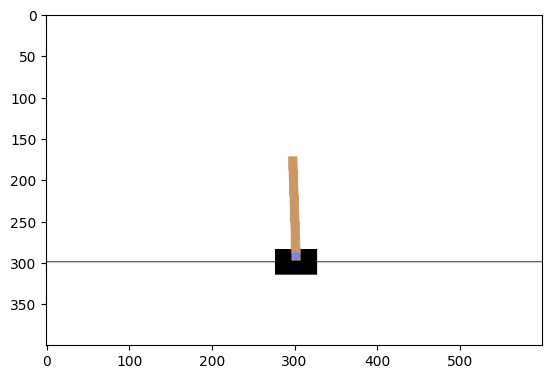

In [3]:
env_name = 'CartPole-v1'
seed=123

env = make_env(env_name)
env.reset(seed=seed)
plt.imshow(env.render())
state_shape, n_actions = env.observation_space.shape, env.action_space.n
state_dim = state_shape[0]
print(f"state shape:{state_shape}\nNumber of Actions:{n_actions}")

### Build Actor Critic Network

We will build two simple networks that take in state. One network produces logits for the action probabilities. 2nd network produces the Value of the state. The observation space and action space is as given below for CartPole

    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        

Each model will be a simple one with 1 hidden layer with Relu activation and final layer being logits (for policy/actor network) and value of the state for the Critic Network.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.actor = nn.Linear(128,n_actions)
        self.critic = nn.Linear(128,1)


    def forward(self, s):
        x = nn.functional.relu(self.fc1(s))
        logits = self.actor(x)
        state_value = self.critic(x)
        return logits, state_value
        
model = ActorCritic()
model = model.to(device)

### Predict Action Probabilities

We will use this function to generate the trajectory. It will not be used for doing back propagation. So we will use PyTorch `no_grad()` to avoid gradient calculations. 

In [6]:
def sample_action(state):
    """
    params: states: [batch, state_dim]
    returns: probs: [batch, n_actions]
    """
    state = torch.tensor(state, device=device, dtype=torch.float32)
    with torch.no_grad():
        logits,_ = model(state)
    action_probs = nn.functional.softmax(logits, -1).detach().cpu().numpy()[0]
    action = np.random.choice(n_actions, p=action_probs)
    return action

### Play game and generate Trajectory

In [7]:
def generate_trajectory(env, n_steps=1000):
    """
    Play a session and genrate a trajectory
    returns: arrays of states, actions, rewards
    """
    states, actions, rewards = [], [], []
    
    # initialize the environment
    s,_ = env.reset()
    
    #generate n_steps of trajectory:
    for t in range(n_steps):
        #sample action based on action_probs
        a = sample_action(np.array([s]))
        next_state, r, done, _, _ = env.step(a)
        
        #update arrays
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = next_state
        if done:
            break
    
    return np.array(states), np.array(actions), np.array(rewards)

### Evaluation of Agent

In [8]:
def evaluate(env, agent, n_games=3, t_max=10000):
    rewards = []
    for i in range(n_games):
        s,_ = env.reset(seed=seed+i)
        reward = 0
        for _ in range(t_max):
            #sample action based on action_probs
            a = sample_action(np.array([s]))
            next_state, r, terminated, _, _ = env.step(a)
            reward += r
            s = next_state
            if terminated:
                break

        rewards.append(reward)
    return np.mean(rewards)

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

### Calculate Rewards to Go

 $G(s_t) = \sum_{t'=t}^{T} \gamma^{t-t'} r(s_{t'}^i, a_{t'}^i)$

In [9]:
def get_rewards_to_go(rewards, gamma=0.99):
    
    T = len(rewards) # total number of individual rewards
    # empty array to return the rewards to go
    rewards_to_go = [0]*T 
    rewards_to_go[T-1] = rewards[T-1]
    
    for i in range(T-2, -1, -1): #go from T-2 to 0
        rewards_to_go[i] = gamma * rewards_to_go[i+1] + rewards[i]
    
    return rewards_to_go

### Train on one trajectory

We will calculate the loss and take a gradient step. We will use Adam Optimizer

**policy network loss:**

We are taking only one trajectory. so N=1. We will, however, average it over the number of actions to get the average loss. So the function we will actually implement is as given below:


$$Loss(\theta, \phi) = - J(\theta, \phi) - H(\pi_\theta(a_t|s_t)) = - \frac{1}{T}  \left[ \sum_{t=1}^{T} \left(  \log{ \pi_\theta(a_t|s_t)} \left[ \hat{Q}(s_t,\ a_t) - V_\phi(s_t)\right] \right) - \beta \sum_{a} \pi_\theta(a|s_t).\log{ \pi_\theta(a|s_t)} \right] $$


In [10]:
#init Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_one_episode(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    
    # get rewards to go
    rewards_to_go = get_rewards_to_go(rewards, gamma)

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards_to_go = torch.tensor(rewards_to_go, device=device, dtype=torch.float)
    

    # get action probabilities from states
    logits, state_values = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)
    
    log_probs_for_actions = log_probs[range(len(actions)), actions]
    
    advantage = rewards_to_go - state_values.squeeze(-1)
    
    #Compute loss to be minimized
    J = torch.mean(log_probs_for_actions*(advantage))
    H = -(probs*log_probs).sum(-1).mean()
    
    loss = -(J+entropy_coef*H)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.detach().cpu() #to show progress on training
    

### Train the agent

In [11]:
eval_freq = 10
n_episodes = 1000

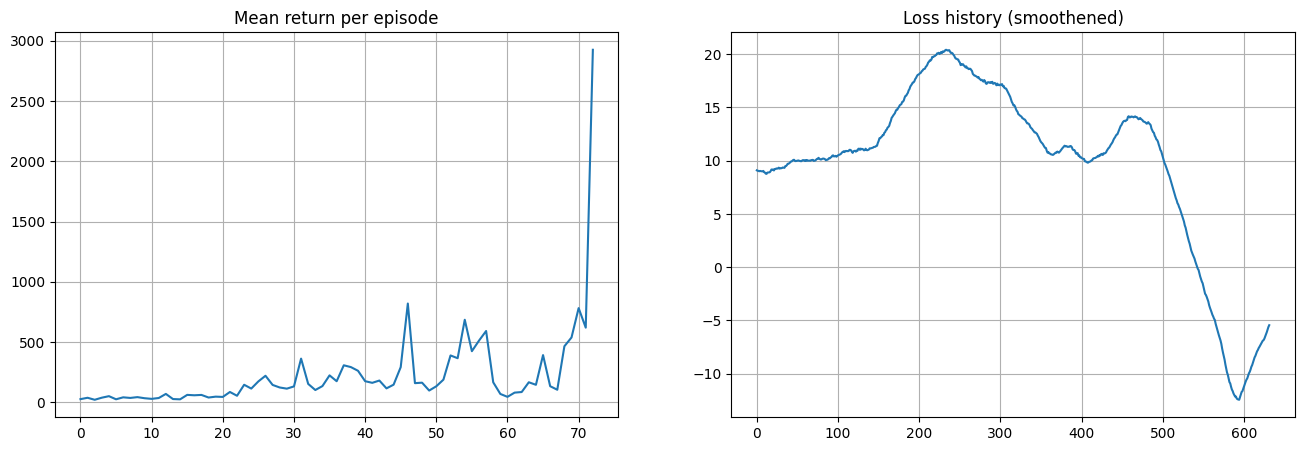

In [12]:
loss_history = []
return_history = []

for i in range(5000):
    states, actions, rewards = generate_trajectory(env)
    loss = train_one_episode(states, actions, rewards)
    # return_history.append(np.sum(rewards))
    loss_history.append(loss)

    if i != 0 and i % eval_freq == 0:
        mean_return = np.mean(return_history[-eval_freq:])
        if mean_return > 500:
            break

    if i != 0 and i % eval_freq == 0:
        # eval the agent
        eval_env = make_env(env_name)
        return_history.append(
            evaluate(eval_env, model)
        )
        eval_env.close()
        clear_output(True)

        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Mean return per episode")
        plt.plot(return_history)
        plt.grid()

        assert not np.isnan(loss_history[-1])
        plt.subplot(1, 2, 2)
        plt.title("Loss history (smoothened)")
        plt.plot(smoothen(loss_history))
        plt.grid()

        plt.show()


env.close()

**Let us record a video of trained agent**

In [13]:
# Helper function to record videos
def record_video(env_id, video_folder, video_length, agent):

    vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id}")

    obs = vec_env.reset()
    for _ in range(video_length + 1):
        action = sample_action(obs)
        obs, _, _, _ = vec_env.step([action])
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]
    # Save the video
    vec_env.close()
    return file_path

def play_video(file_path):
    mp4 = open(file_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
        <video width=400 controls>
              <source src="%s" type="video/mp4">
        </video>
        """ % data_url)


In [14]:
video_folder = "logs/8_b/"
video_length = 500

video_file = record_video(env_name, video_folder, video_length, model)

play_video(video_file)

Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter8/logs/8_b/ActorCritic-CartPole-v1-step-0-to-step-500.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter8/logs/8_b/ActorCritic-CartPole-v1-step-0-to-step-500.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter8/logs/8_b/ActorCritic-CartPole-v1-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter8/logs/8_b/ActorCritic-CartPole-v1-step-0-to-step-500.mp4


### Conclusion
In this notebook we saw how A2C works. From the graphs we can notice that Grpahs of learning are lot smoother and policy learnt by the agent is also of higher quality as comapred to REINFORCE.